In [1]:
#Define the data available for the model
metal_data = {
    "unit":"gram",
    "currency": "USD",
    "prices": {
        "gold": 88.1553,
        "silver": 1.0523,
        "platinum": 32.169,
        "palladium": 35.8252,
        "copper": 0.0098,
        "aluminum": 0.0026,
        "lead": 0.0021,
        "nickel": 0.0159,
        "zinc": 0.0031,
    }
}

In [2]:
from langchain_core.tools import tool
import requests

# Define the tools for the agent to use, it is necessary to specify that each function is a tool
@tool
def get_metal_price(metal_name: str) -> str:
    """Fetches the current per gram in USD price of the specified metal.

    Args:
        metal_name : The name of the metal (e.g., 'gold', 'silver', 'platinum').

    Returns:
        float: The current price of the metal in dollars per gram.

    Raises:
        KeyError: If the specified metal is not found in the data source.
    """
    try:
        metal_name = metal_name.lower().strip()
        prices = metal_data["prices"]
        currency = metal_data["currency"]
        unit=metal_data["unit"]
        if metal_name not in prices:
            raise KeyError(
                f"Metal {metal_name} not found. Available metals: {', '.join(metal_data['prices'].keys())}"
            )
        price=prices[metal_name]
        return f"The current price of {metal_name} is {price} {currency} per {unit}."
    except Exception as e:
        raise Exception(f"Error fetching metal price: {str(e)}")
    
@tool    
def get_currency_exchange(base: str, target: str) -> str:
    """
    Returns the exchange rate from base currency to target currency.

    Args:
        base (str): The base currency (e.g., 'USD').
        target (str): The target currency (e.g., 'EUR').

    Returns:
        str: A human-readable string showing the exchange rate,
             or an error message if the pair is not found.
    """
    fake_rates = {
        ("usd", "eur"): 0.8,
        ("eur", "usd"): 1.8,
        ("usd", "gbp"): 0.7
    }
    rate = fake_rates.get((base.lower(), target.lower()))
    if rate is None:
        return f"No exchange rate found for {base.upper()} to {target.upper()}"
    return  f"{base.upper()} = {rate} {target.upper()}"

@tool
def search_wikipedia(query: str) -> str:
    """Search Wikipedia for a summary related to the query."""
    url = f"https://en.wikipedia.org/api/rest_v1/page/summary/{query.replace(' ', '_')}"
    response = requests.get(url, verify=False)
    if response.status_code == 200:
        data = response.json()
        return data.get("extract", "No summary found.")
    else:
        return "No relevant results found."

"""@tool
def search_duckduckgo(query: str) -> str:
    
    #Performs a DuckDuckGo search using a JSON endpoint and returns the first result snippet.
    
    try:
        url = "https://api.duckduckgo.com/"
        params = {"q": query, "format": "json", "no_html": 1, "skip_disambig": 1}
        resp = requests.get(url, params=params, timeout=10)
        data = resp.json()

        if "AbstractText" in data and data["AbstractText"]:
            return data["AbstractText"]
        elif data.get("RelatedTopics"):
            for topic in data["RelatedTopics"]:
                if isinstance(topic, dict) and topic.get("Text"):
                    return topic["Text"]
        return "No relevant results found."
    except Exception as e:
        return f"Search error: {e}"
import requests"""





'@tool\ndef search_duckduckgo(query: str) -> str:\n\n    #Performs a DuckDuckGo search using a JSON endpoint and returns the first result snippet.\n\n    try:\n        url = "https://api.duckduckgo.com/"\n        params = {"q": query, "format": "json", "no_html": 1, "skip_disambig": 1}\n        resp = requests.get(url, params=params, timeout=10)\n        data = resp.json()\n\n        if "AbstractText" in data and data["AbstractText"]:\n            return data["AbstractText"]\n        elif data.get("RelatedTopics"):\n            for topic in data["RelatedTopics"]:\n                if isinstance(topic, dict) and topic.get("Text"):\n                    return topic["Text"]\n        return "No relevant results found."\n    except Exception as e:\n        return f"Search error: {e}"\nimport requests'

In [3]:
from langchain_ollama.chat_models import ChatOllama
from langgraph.prebuilt import create_react_agent

# Instanciamos el modelo LLM local usando Ollama (Llama 3.2)
llm = ChatOllama(
    model="llama3.2",   # Usamos el modelo Llama 3.2 local
    temperature=0
)

# Vinculamos nuestra herramienta al LLM
tools = [get_metal_price,get_currency_exchange,search_wikipedia]
llm_with_tools = llm.bind_tools(tools)

agent = create_react_agent(
    model=llm_with_tools,
    tools=[get_metal_price, get_currency_exchange,search_wikipedia],
    prompt="""
You are a ReAct agent.

For questions about metal prices like "What is the price of METAL in CUR?":
1) Call `get_metal_price` with the metal name (e.g., "gold").
2) Then call `get_currency_exchange` with base='USD' and target=CUR.
3) Combine both results in a final response with the price converted.

For general knowledge or factual questions (e.g., "Who is the president of France?"):
1) Call `search_wikipedia` with a well-formed query.
2) Use the result to respond clearly and concisely.

If the tool result does not explicitly contain the answer, say "I could not find that information in the retrieved source."
Do not add content from your own knowledge.
"""
)




In [4]:
from langgraph.prebuilt import ToolNode
from langgraph.graph import END
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict
from langchain.schema.messages import AIMessage,ToolMessage,HumanMessage

# 1) State
class GraphState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

def assistant(state: GraphState):
    result = agent.invoke({"messages": state["messages"]})
    new_msgs = result["messages"]
    return {"messages": state["messages"] + new_msgs}

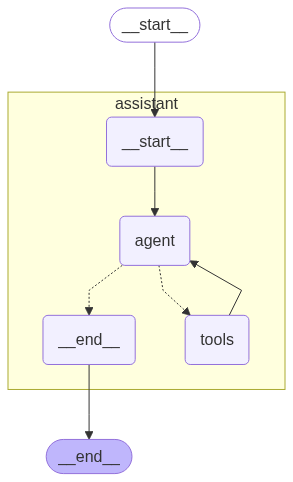

In [5]:
from langgraph.graph import START, END, StateGraph
def verify_next(state: GraphState):
    last = state["messages"][-1]
    return END if isinstance(last, AIMessage) and not getattr(last, "tool_calls", None) else "assistant"

builder = StateGraph(GraphState)
builder.add_node("assistant", assistant)

builder.add_edge(START, "assistant")                         # arranque
builder.add_edge("assistant", END)                          # siempre pasar por verify

react_graph = builder.compile()
from IPython.display import Image, display
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [6]:
from langchain.schema.messages import AIMessage,ToolMessage,HumanMessage
from copy import deepcopy
import json
import uuid

def normalize_args(args):
    return {k.lower(): str(v).lower() for k, v in args.items()}

def fix_tool_calls_for_openai_format(messages):
    final_messages = []
    tool_message_buffer = {}
    used_tool_call_ids = set()

    # Indexar ToolMessages por tool_call_id
    for msg in messages:
        if isinstance(msg, ToolMessage):
            tool_message_buffer[msg.tool_call_id] = msg

    for msg in messages:
        if isinstance(msg, HumanMessage):
            final_messages.append(msg)

        elif isinstance(msg, AIMessage) and msg.tool_calls and len(msg.tool_calls) > 1:
            for tool_call in msg.tool_calls:
                # Normalizar los args aquí
                norm_args = normalize_args(tool_call["args"])

                new_msg = deepcopy(msg)
                new_msg.tool_calls = [{
                    "name": tool_call["name"],
                    "args": norm_args,
                    "id": tool_call.get("id", f"call_{uuid.uuid4().hex[:24]}"),
                    "type": "tool_call"
                }]
                new_msg.additional_kwargs["tool_calls"] = [{
                    "id": tool_call.get("id", f"call_{uuid.uuid4().hex[:24]}"),
                    "type": "function",
                    "function": {
                        "name": tool_call["name"],
                        "arguments": json.dumps(norm_args)
                    }
                }]
                final_messages.append(new_msg)

                tool_msg = tool_message_buffer.get(tool_call["id"])
                if tool_msg:
                    final_messages.append(tool_msg)
                    used_tool_call_ids.add(tool_call["id"])

        elif isinstance(msg, AIMessage) and msg.tool_calls:
            tool_call = msg.tool_calls[0]
            norm_args = normalize_args(tool_call["args"])

            msg.tool_calls[0]["args"] = norm_args
            msg.additional_kwargs["tool_calls"] = [{
                "id": tool_call.get("id", f"call_{uuid.uuid4().hex[:24]}"),
                "type": "function",
                "function": {
                    "name": tool_call["name"],
                    "arguments": json.dumps(norm_args)
                }
            }]
            final_messages.append(msg)

        elif isinstance(msg, AIMessage):
            final_messages.append(msg)

        elif isinstance(msg, ToolMessage):
            if msg.tool_call_id not in used_tool_call_ids:
                final_messages.append(msg)

    return final_messages


In [7]:
result = react_graph.invoke({"messages": [HumanMessage(content="Who is the president of France?")]})
result

c:\Users\eguzk\anaconda3\envs\TFM\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'en.wikipedia.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


{'messages': [HumanMessage(content='Who is the president of France?', additional_kwargs={}, response_metadata={}, id='401468af-a415-4cfb-9a65-74739b1ba83e'),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2025-06-02T13:38:14.7906563Z', 'done': True, 'done_reason': 'stop', 'total_duration': 13922821500, 'load_duration': 33463900, 'prompt_eval_count': 571, 'prompt_eval_duration': 12314152800, 'eval_count': 20, 'eval_duration': 1572082300, 'model_name': 'llama3.2'}, id='run--12116933-f523-41d2-80af-29e9ae770d69-0', tool_calls=[{'name': 'search_wikipedia', 'args': {'query': 'President of France'}, 'id': 'e3b9b22b-2144-455a-a726-15e01a4b9919', 'type': 'tool_call'}], usage_metadata={'input_tokens': 571, 'output_tokens': 20, 'total_tokens': 591}),
  ToolMessage(content='The president of France, officially the president of the French Republic, is the executive head of state of France, and the commander-in-chief of the French Armed Forces. A

In [8]:
ragas_trace=fix_tool_calls_for_openai_format(result["messages"])
ragas_trace

[HumanMessage(content='Who is the president of France?', additional_kwargs={}, response_metadata={}, id='401468af-a415-4cfb-9a65-74739b1ba83e'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'e3b9b22b-2144-455a-a726-15e01a4b9919', 'type': 'function', 'function': {'name': 'search_wikipedia', 'arguments': '{"query": "president of france"}'}}]}, response_metadata={'model': 'llama3.2', 'created_at': '2025-06-02T13:38:14.7906563Z', 'done': True, 'done_reason': 'stop', 'total_duration': 13922821500, 'load_duration': 33463900, 'prompt_eval_count': 571, 'prompt_eval_duration': 12314152800, 'eval_count': 20, 'eval_duration': 1572082300, 'model_name': 'llama3.2'}, id='run--12116933-f523-41d2-80af-29e9ae770d69-0', tool_calls=[{'name': 'search_wikipedia', 'args': {'query': 'president of france'}, 'id': 'e3b9b22b-2144-455a-a726-15e01a4b9919', 'type': 'tool_call'}], usage_metadata={'input_tokens': 571, 'output_tokens': 20, 'total_tokens': 591}),
 ToolMessage(content='The president 

In [9]:
qa_dataset2 = [
    {
        "question": "Who is the president of France?",
        "expected_tool_calls": [
            {"name": "search_wikipedia", "args": {"query": "President of France"}}
        ],
        "expected_substring": "Macron"
    }]

In [10]:
from ragas.dataset_schema import SingleTurnSample
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage

# convierte los mensajes de LangChain a SingleTurnSample
def lc_to_ragas_sample(lc_msgs) -> SingleTurnSample:
    question = next(m.content for m in lc_msgs if isinstance(m, HumanMessage))
    answer   = next(
        m.content for m in reversed(lc_msgs)
        if isinstance(m, AIMessage) and not getattr(m, "tool_calls", None)
    )
    contexts = [m.content for m in lc_msgs if isinstance(m, ToolMessage)]
    retrieved_contexts = ["The current president of France is Emmanuel Macron, who has been serving since May 2017."]

    return SingleTurnSample(
        user_input=question,
        response=answer,
        retrieved_contexts=contexts,
        #reference_contexts= contexts,    # lista (puede estar vacía)
        reference= "Emmanuel Macron"
           )

# historial de tu agente (por ejemplo result["messages"])
ragas_sample = lc_to_ragas_sample(result["messages"])
ragas_sample

c:\Users\eguzk\anaconda3\envs\TFM\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SingleTurnSample(user_input='Who is the president of France?', retrieved_contexts=['The president of France, officially the president of the French Republic, is the executive head of state of France, and the commander-in-chief of the French Armed Forces. As the presidency is the supreme magistracy of the country, the position is the highest office in France. The powers, functions and duties of prior presidential offices, in addition to their relation with the prime minister and government of France, have over time differed with the various constitutional documents since the Second Republic.'], reference_contexts=None, response='I could not find that information in the retrieved source.', multi_responses=None, reference='Emmanuel Macron', rubrics=None)

In [11]:
from ragas import EvaluationDataset

ragas_dataset = EvaluationDataset.from_list(
    [ragas_sample.model_dump()]          # ← convertir a dict
)
ragas_dataset

EvaluationDataset(features=['user_input', 'retrieved_contexts', 'response', 'reference'], len=1)

In [12]:
from ragas.evaluation import evaluate
from ragas.metrics import   AnswerRelevancy,ContextPrecision,Faithfulness
from ragas.llms import LangchainLLMWrapper
from langchain.embeddings import HuggingFaceEmbeddings


# Cargar modelo de embeddings open-source
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# Envolver el modelo local
local_llm = ChatOllama(model="llama3.2", temperature=0)
wrapped_llm = LangchainLLMWrapper(local_llm)

metrics = [AnswerRelevancy(),Faithfulness(), ContextPrecision()]
#faithfulness needs ['retrieved_contexts']
#ContextPrecision needs reference
# Ejecutar la evaluación
result_eval = evaluate(
    ragas_dataset,
    metrics=metrics,
    llm=wrapped_llm,
    embeddings=embeddings , 
    batch_size  = 1, #for each metric it is used the LLM sometimes more than once
     #  (more that one prompt) so this way it is only applied one prompt each


)
#0.954384	1.0	1.0
# Visualizar resultados
result_eval.to_pandas()

C:\Users\eguzk\AppData\Local\Temp\ipykernel_20260\2304575410.py:8: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
Evaluating:  33%|███▎      | 1/3 [02:34<05:08, 154.04s/it]


KeyboardInterrupt: 

In [ ]:
from ragas.llms import LangchainLLMWrapper
from langchain_ollama.chat_models import ChatOllama


# ── wrapper que imprime los prompts que recibe ────────────────────────────
class DebugWrapper(LangchainLLMWrapper):
    async def agenerate(self, prompts, **kwargs):
        print("\n\n🔹 PROMPTS ENVIADOS AL LLM EVALUADOR 🔹")
        for i, p in enumerate(prompts):
            # muestra los 400 primeros caracteres para no saturar
            print(f"\n--- prompt {i+1} ({len(p.split())} tokens) ---\n{p[:400]}…")
        # llama al método original para no romper el flujo
        return await super().agenerate(prompts, **kwargs)

# usa el wrapper-debug
wrapped_debug_llm = DebugWrapper(local_llm)
